# Deep learning meets missing data: Doing it MIWAE


# Multivariate normal distribution

In this notebook, we'll show how to learn a deep generative model on a small(ish) and **incomplete** continuous data set. We will also show how to **impute** the missing values of this data set. 

This is based on the following paper, available [on the ICML website](http://proceedings.mlr.press/v97/mattei19a.html):

P.-A. Mattei & J. Frellsen, **MIWAE: Deep Generative Modelling and Imputation of Incomplete Data Sets**, *Proceedings of the 36th International Conference on Machine Learning*, PMLR 97:4413-4423, 2019.

It is possible to run this notebook in Google Colab, which allows to benefit from free GPU computing.
<table class="tfo-notebook-buttons" align="left">
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/pamattei/MIWAE_demo_UCI.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


# Installing and loading useful stuff

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn import preprocessing
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [ ]:
def mse(xhat,xtrue,mask): # MSE function for imputations
    mask = mask.astype(np.bool)
    xhat = np.array(xhat)
    xtrue = np.array(xtrue)
    return np.mean(np.power(xhat-xtrue,2)[~mask])

# Creating the synthetic data set

We'll use a synthetic data set made of samples from a mutltivariate Gaussian distribution.



In [ ]:
dim = 2
mu_true = np.zeros(dim)
cov_true = np.eye(dim)+1 # example suggested by Maria Skoularidou
data=np.random.multivariate_normal(mean=mu_true, cov =cov_true, size=1000)

We don't standardise the data since they are already quite well-behaved.

In [ ]:
xfull = data.astype(np.float32)
n = xfull.shape[0] # number of observations
p = xfull.shape[1] # number of features

We will remove uniformy at random 50% of the data. This 
corresponds to a *missing completely at random (MCAR)* scenario. The MIWAE also works in more challenging *missing at random (MAR)* situations. For more info on what MCAR, MAR, and MNAR mean, you can look for example at [these nice lecture notes](http://juliejosse.com/wp-content/uploads/2018/07/LectureNotesMissing.html) by Julie Josse, Wei Jiang, Aude Sportisse, and Geneviève Robin. We are also working on an [extension of MIWAE to handle MNAR data](https://arxiv.org/abs/2006.12871).

In [ ]:
np.random.seed(1234)

perc_miss = 0.5 # 50% of missing data
xmiss = np.copy(xfull)
xmiss_flat = xmiss.flatten()
miss_pattern = np.random.choice(n*p, np.floor(n*p*perc_miss).astype(np.int), replace=False)
xmiss_flat[miss_pattern] = np.nan 
xmiss = xmiss_flat.reshape([n,p]) # in xmiss, the missing values are represented by nans
mask = np.isfinite(xmiss).astype(np.float32) # binary mask that indicates which values are not missing

A simple way of imputing the incomplete data is to replace the missing values by zeros. This $\texttt{x_hat0}$ corresponds to these *zero-imputed data*.

In [ ]:
xhat_0 = np.copy(xmiss)
xhat_0[np.isnan(xmiss)] = 0

# Model building

We will use a **deep latent variable model with a Gaussian prior and a Student's t observation model**. This can be written:

$$p(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p(\mathbf{x}_i|\mathbf{z}_i) = \text{St} (\mathbf{x}_i|\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\mu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}^p$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$ are functions parametrised by deep neural nets.

The weights of these nets are stored in a parameter $\boldsymbol{\theta}$. We choose to use the following simple architecture, where the 3 neural nets share the first layers:

$$f_{\boldsymbol{\theta}} (\mathbf{z})=\sigma(\mathbf{W}_1\sigma(\mathbf{W}_0\mathbf{z}+\mathbf{b}_0)+\mathbf{b}_1) $$

$$\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{W}_\boldsymbol{\mu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\mu}, $$

$$\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Diag}\left(\text{Softplus}(\mathbf{W}_\boldsymbol{\sigma}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\sigma}) + 10^{-3}\right), $$

$$\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Softplus}(\mathbf{W}_\boldsymbol{\nu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\nu}) + 3. $$

A few **non-essential remarks** about this architecture:

* This parametrisation is quite close to the one we use in the MIWAE paper. The main difference is that we use $\sigma = \text{ReLU}$ (which leads to faster training) while we used $\sigma = \text{tanh}$ in the paper.
*   We use a [location-scale parametrisation](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family) of the t distribution, following [the parametrisation available in TensorFlow](https://www.tensorflow.org/api_docs/python/tf/distributions/StudentT). Note in particular that $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ is not the covariance matrix of $\mathbf{x} | \mathbf{z}$. When it exitsts, the actual covariance matrix is diagonal with diagonal  $$ \frac{\text{diag}(\boldsymbol{\Sigma}_{\boldsymbol{\theta}} (\mathbf{z}))^2 \boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})}{\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})-2}$$ (where all operations are made entrywise).
*   The fact that the covariance matrix is diagonal means that we assume that **the features are independent conditionnally on the latent variable** (which is customary for DLVMs).
* We add $3$ to the neural net that outputs the degrees of freedom. This is to guarantee that the tails of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are not too heavy. Indeed, having too heavy tails might imply that the mean of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ does not exist! Adding 3 implies that the degrees of freedom is always larger than 3, implying in turn that **at least the first 3 moments of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are well-defined.**
* We add $10^{-3}$ to the diagonal entries of $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}$ to prevent singularities, [as advocated in our NeurIPS 2018 paper](https://papers.nips.cc/paper/7642-leveraging-the-exact-likelihood-of-deep-latent-variable-models). Why $10^{-3}$ specifically? Because, since the data have unit variance, this will imply that the latent variable explains at most $99.9999\%$ of the variance of the data, which does not seem too restrictive. **This choice might be poor if the data are not standardised.**




Since the data are fairly simple in this case, we make the strong assumption that the latent space is of dimension $d = 1$. This roughly means that we assume that the data lie close to a nonlinear manifold of dimension $1$.

In [ ]:
d = 1 # 1D manifold
p_z = tfd.MultivariateNormalDiag(loc=tf.zeros(d, tf.float32))

In [ ]:
h = 128 # number of hidden units (same for all MLPs)

sigma = "relu"

decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma,kernel_initializer="he_normal"),
  tfkl.Dense(h, activation=sigma,kernel_initializer="he_normal"),
  tfkl.Dense(3*p,kernel_initializer="he_normal") # the decoder will output both the mean, the scale, and the number of degrees of freedoms (hence the 3*p)
])

#Building the inference network (*aka* encoder)

We will build a Student's t posterior approximation by using an **encoder** that mimicks the architecture of the decoder.


The imputation function $\iota$ replaces the missing values by learned constants. Note that this is slightly more general than what we use in the paper (which was just replacing missing values by zeros). We just initialise it using zeros.

In [ ]:
iota = tf.Variable(np.zeros([1,p]),dtype=tf.float32)

In [ ]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[p,]),
  tfkl.Dense(h, activation=sigma,kernel_initializer="he_normal"),
  tfkl.Dense(h, activation=sigma,kernel_initializer="he_normal"),
  tfkl.Dense(3*d,kernel_initializer="he_normal")
])

# Computing the MIWAE bound

We now have everything we need to compute our lower-bound on the log-likelihood of the observed data. The MIWAE bound is defined as
$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}^\text{o}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i^\text{o}|\mathbf{z}_{ik})p(\mathbf{z}_{ik})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}^\text{o}_i)} \right].
$$

In [ ]:
@tf.function
def miwae_bound(xhat_0_batch, mask_batch,K):

  tiledmask = tf.tile(mask_batch,[K,1])
  mask_complement_float = tf.abs(mask_batch-1)

  tilediota = tf.tile(iota,[xhat_0_batch.shape[0],1])
  iotax = xhat_0_batch + tf.multiply(tilediota,mask_complement_float)

  out_encoder = encoder(iotax)
  q_zgivenxobs = tfd.Independent(distribution=tfd.StudentT(loc=out_encoder[..., :d], scale=tf.nn.softplus(out_encoder[..., d:(2*d)]), df=3 + tf.nn.softplus(out_encoder[..., (2*d):(3*d)])))
  zgivenx = q_zgivenxobs.sample(K)
  zgivenx_flat = tf.reshape(zgivenx,[K*xhat_0_batch.shape[0],d])

  out_decoder = decoder(zgivenx_flat)
  data_flat = tf.reshape(tf.tile(xhat_0_batch,[K,1]),[-1,1])
  all_means_obs_model = out_decoder[..., :p]
  all_scales_obs_model = tf.nn.softplus(out_decoder[..., p:(2*p)]) + 0.001
  all_degfreedom_obs_model = tf.nn.softplus(out_decoder[..., (2*p):(3*p)]) + 3
  all_log_pxgivenz_flat = tfd.StudentT(loc=tf.reshape(all_means_obs_model,[-1,1]),scale=tf.reshape(all_scales_obs_model,[-1,1]),df=tf.reshape(all_degfreedom_obs_model,[-1,1])).log_prob(data_flat)
  all_log_pxgivenz = tf.reshape(all_log_pxgivenz_flat,[K*xhat_0_batch.shape[0],p])

  logpxobsgivenz = tf.reshape(tf.reduce_sum(tf.multiply(all_log_pxgivenz,tiledmask),1),[K,xhat_0_batch.shape[0]])
  logpz = p_z.log_prob(zgivenx)
  logq = q_zgivenxobs.log_prob(zgivenx)

  average_miwae_bound = tf.reduce_mean(tf.reduce_logsumexp(logpxobsgivenz + logpz - logq,0) -tf.math.log(tf.cast(K,tf.float32)) ) 
  return average_miwae_bound

# Single imputation

The optimal (in the $\ell_2$ sense, and according to our model $p_{\boldsymbol{\theta}}$) single imputation is the conditional mean $\mathbb{E}_{p_{\boldsymbol{\theta}}} [\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}}]$. This can be estimated using self-normalised importance sampling:
\begin{equation}
\mathbb E _{p_{\boldsymbol{\theta}}}[\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}}] \approx \sum_{l=1}^L w_l \mathbb{E}_{p_{\boldsymbol{\theta}}}\left[\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}},\mathbf{z}_{(l)}\right] = \sum_{l=1}^L w_l \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}_l)^\text{m},
\end{equation}


\begin{equation}
w_l=\frac{r_l}{r_1+...+r_L}, \; \text{with} \; r_l = \frac{p_{\boldsymbol{\theta}}(\mathbf{x}^{\text{o}}|\mathbf{z}_{(l)})p(\mathbf{z}_{(l)})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{(l)}|\mathbf{x}^{\text{o}})}.
\end{equation}

For more details on this, see section 3.2 of the [MIWAE paper](http://proceedings.mlr.press/v97/mattei19a.html).

In [ ]:
@tf.function
def miwae_impute(xhat_0_batch, mask_batch,K=1000,type="single",num_samples=20):

  tiledmask = tf.tile(mask_batch,[K,1])
  mask_complement_float = tf.abs(mask_batch-1)

  tilediota = tf.tile(iota,[xhat_0_batch.shape[0],1])
  iotax = xhat_0_batch + tf.multiply(tilediota,mask_complement_float)

  out_encoder = encoder(iotax)
  q_zgivenxobs = tfd.Independent(distribution=tfd.StudentT(loc=out_encoder[..., :d], scale=tf.nn.softplus(out_encoder[..., d:(2*d)]), df=3 + tf.nn.softplus(out_encoder[..., (2*d):(3*d)])))
  zgivenx = q_zgivenxobs.sample(K)
  zgivenx_flat = tf.reshape(zgivenx,[K*xhat_0_batch.shape[0],d])

  out_decoder = decoder(zgivenx_flat)
  data_flat = tf.reshape(tf.tile(xhat_0_batch,[K,1]),[-1,1])
  all_means_obs_model = out_decoder[..., :p]
  all_scales_obs_model = tf.nn.softplus(out_decoder[..., p:(2*p)]) + 0.001
  all_degfreedom_obs_model = tf.nn.softplus(out_decoder[..., (2*p):(3*p)]) + 3
  xgivenz = tfd.Independent(distribution=tfd.StudentT(loc=all_means_obs_model, scale=all_scales_obs_model, df=all_degfreedom_obs_model))
  all_log_pxgivenz_flat = tfd.StudentT(loc=tf.reshape(all_means_obs_model,[-1,1]),scale=tf.reshape(all_scales_obs_model,[-1,1]),df=tf.reshape(all_degfreedom_obs_model,[-1,1])).log_prob(data_flat)
  all_log_pxgivenz = tf.reshape(all_log_pxgivenz_flat,[K*xhat_0_batch.shape[0],p])

  logpxobsgivenz = tf.reshape(tf.reduce_sum(tf.multiply(all_log_pxgivenz,tiledmask),1),[K,xhat_0_batch.shape[0]])
  logpz = p_z.log_prob(zgivenx)
  logq = q_zgivenxobs.log_prob(zgivenx)

  imp_weights = tf.nn.softmax(logpxobsgivenz + logpz - logq,0) # these are w_1,....,w_L for all observations in the batch
  xms = tf.reshape(xgivenz.mean(),[K,xhat_0_batch.shape[0],p])
  xm = xhat_0_batch + tf.multiply(tf.einsum('ki,kij->ij', imp_weights, xms),mask_complement_float)
  return xm

# Training the model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [ ]:
all_parameters = encoder.trainable_variables + decoder.trainable_variables + [iota]

In [ ]:
@tf.function
def gradient_step_miwae(xhat_0_batch, mask_batch,K):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    loss = -  miwae_bound(xhat_0_batch, mask_batch,K)  # the loss is the negative ELBO
  gradients = tape.gradient(loss, all_parameters)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, all_parameters))  # Adam iteration

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((xhat_0,mask)).shuffle(n).batch(32) # TF creates the batches for us

In [ ]:
EPOCHS = 201
mse_miwae=np.array([])
xhat_miwae = np.copy(xhat_0)

for epoch in range(1,EPOCHS+1):
  for xhat_0_batch, mask_batch in train_dataset:
    gradient_step_miwae(xhat_0_batch, mask_batch,K = 5) # Adam iteration
  
  if (epoch % 20) == 1:
    for i in range(n):
      xhat_miwae[i,:]  = miwae_impute(xhat_0[i,:].reshape([1,p]), mask[i,:].reshape([1,p]),K = 100).numpy()
    err = np.array([mse(xhat_miwae,xfull,mask)])
    train_miwae_bound = miwae_bound(xhat_0, mask, K = 5)
    mse_miwae = np.append(mse_miwae,err,axis=0)
    print('Epoch  %g' %epoch)
    print('Train MIWAE bound  %g' %train_miwae_bound.numpy())
    print('Imputation MSE  %g' %err)
    print('-----------')

Epoch  1
Train MIWAE bound  -1.84486
Imputation MSE  2.12684
-----------
Epoch  21
Train MIWAE bound  -1.74863
Imputation MSE  1.81742
-----------
Epoch  41
Train MIWAE bound  -1.7384
Imputation MSE  1.85596
-----------
Epoch  61
Train MIWAE bound  -1.74223
Imputation MSE  1.80937
-----------
Epoch  81
Train MIWAE bound  -1.73738
Imputation MSE  1.83571
-----------
Epoch  101
Train MIWAE bound  -1.72813
Imputation MSE  1.8256
-----------
Epoch  121
Train MIWAE bound  -1.72597
Imputation MSE  1.81171
-----------
Epoch  141
Train MIWAE bound  -1.74156
Imputation MSE  1.82464
-----------
Epoch  161
Train MIWAE bound  -1.72695
Imputation MSE  1.8183
-----------
Epoch  181
Train MIWAE bound  -1.73362
Imputation MSE  1.79428
-----------
Epoch  201
Train MIWAE bound  -1.72169
Imputation MSE  1.82787
-----------


# Comparison with other techniques

How good are our imputations? Let us compare the results with other imputations techniques.

If we were an oracle that knew the true data distribution $p_\text{data}$, then the optimal imputation would be to use the conditional distribution $\mathbb{E}_{p_\text{data}} [\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}}]$. In this synthetic example, we actually know that $p_\text{data}$ is Gaussian, which means that $\mathbb{E}_{p_\text{data}} [\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}}]$ can be computed in closed-form. This **oracle Gaussian imputation** is impossible to beat on this particular data set, and will be our gold-standard.

The following two functions compute this oracle Gaussain imputation.

In [ ]:
def conditional_gaussian(x,m,mean,cov): # computes the conditional distribution of xmiss given xobs, assuming that x is Gaussian(mean,cov), inspired by code from the R package condMVNorm
  m = m.astype(np.bool)
  obs = m
  miss = ~m
  xobs = x[obs]

  B = cov[np.ix_(miss,miss)]
  C = cov[np.ix_(miss,obs)]
  D = cov[np.ix_(obs,obs)]
  CDinv = np.matmul(C,np.linalg.inv(D))
  cond_mean = mean[miss] + np.matmul(CDinv , xobs - mean[obs])
  cond_cov = B - np.matmul(CDinv,C.T)

  return scipy.stats.multivariate_normal(cond_mean,cond_cov)

In [ ]:
def gaussian_single_impute(x,m,mean,cov): 

  if (m==np.ones(len(x))).all():
    return x

  m = m.astype(np.bool)
  obs = m
  miss = ~m
  xhat = np.copy(x)
  xmiss = conditional_gaussian(x,m,mean,cov).mean
  xhat[~m] = xmiss

  return xhat

We will also look at two popular imputation schemes: **mean imputation**, and the **Missforest algorithm** [(Stekhoven & Bühlmann ,2011)](https://academic.oup.com/bioinformatics/article/28/1/112/219101), or rather a [version of it](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py) implemented the in scikit-learn library.

In [ ]:
missforest = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100), max_iter = 100)
missforest.fit(xmiss)
xhat_mf = missforest.transform(xmiss)
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
mean_imp.fit(xmiss)
xhat_mean = mean_imp.transform(xmiss)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [ ]:
xhat_oracle = np.copy(xhat_0)
for i in range(n):
  xhat_oracle[i,:] = gaussian_single_impute(xhat_0[i,:],mask[i,:], mean = np.zeros(dim), cov =np.eye(dim)+1)

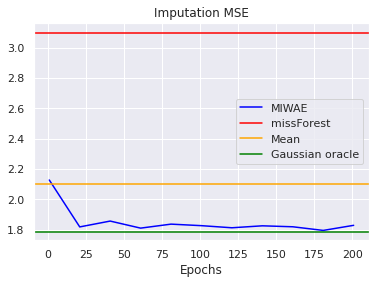

In [ ]:
plt.plot(np.linspace(1,EPOCHS,mse_miwae.shape[0]),mse_miwae,color="blue")
plt.axhline(y=mse(xhat_mf,xfull,mask),  linestyle='-',color="red")
plt.axhline(y=mse(xhat_mean,xfull,mask),  linestyle='-',color="orange")
plt.axhline(y=mse(xhat_oracle,xfull,mask),  linestyle='-',color="green")
plt.legend(["MIWAE","missForest","Mean","Gaussian oracle"])
plt.title("Imputation MSE")
plt.xlabel("Epochs")
plt.show()

As we can seen, missForest is surprisingly outperformed by the mean imputation (which may be explained by the rather weak correlations between the variables) to overfit the data significantly. MIWAE almost reaches the best possible performance, which is remarkable given how overparametrised the model is, compared to the true data distribution.

# Sampling from the model

Another way to check if the model is any good is to sample a bunch of points from it and compare them to the true data distribution.

In [ ]:
@tf.function
def miwae_sample(num_samples=20):

  codes = p_z.sample(num_samples)

  out_decoder = decoder(codes)
  all_means_obs_model = out_decoder[..., :p]
  all_scales_obs_model = tf.nn.softplus(out_decoder[..., p:(2*p)]) + 0.001
  all_degfreedom_obs_model = tf.nn.softplus(out_decoder[..., (2*p):(3*p)]) + 3
  xgivenz = tfd.Independent(distribution=tfd.StudentT(loc=all_means_obs_model, scale=all_scales_obs_model, df=all_degfreedom_obs_model))
  x = xgivenz.sample(1)

  return tf.squeeze(x)

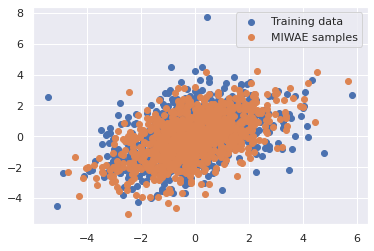

In [ ]:
fake_data = miwae_sample(n)

plt.scatter(fake_data[:,0],fake_data[:,1])
plt.scatter(xfull[:,0],xfull[:,1])
plt.legend(["Training data", "MIWAE samples"])
plt.show()

One may also look at the marginals:

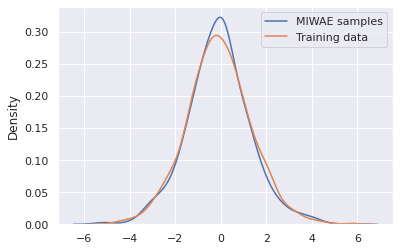

In [ ]:
sns.kdeplot(fake_data[:,0])
sns.kdeplot(xfull[:,0])
plt.legend([ "MIWAE samples","Training data"])
plt.show()

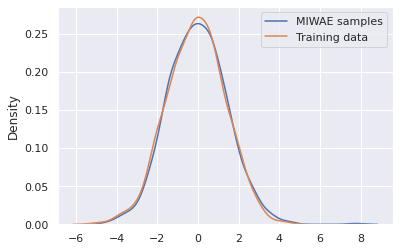

In [ ]:
sns.kdeplot(fake_data[:,1])
sns.kdeplot(xfull[:,1])
plt.legend([ "MIWAE samples","Training data"])
plt.show()